I'm going to investigate the effect of dropouts in this notebook.

In [1]:
#importing libraries
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
#allocating datasets and model to GPU for speed's sake
is_available = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
   
def clean_target(x): #this is the function we want to approximate
    return np.power(x, 5) - 10 * np.power(x, 1) + 1


def target(x): #this is the function with noise
    return clean_target(x) - 1 + 2*torch.rand(x.size())


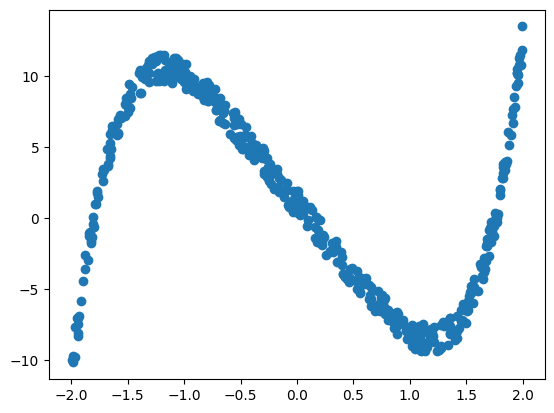

In [3]:
#creating training data
x_train = torch.rand(500)*4-2
y_train = target(x_train)

plt.scatter(x_train.data.numpy(), y_train.data.numpy())
plt.show()

#allocating training data to GPU
x_train = torch.unsqueeze(x_train, dim=1).to(device)
y_train = torch.unsqueeze(y_train, dim=1).to(device)


Here's where I diverge from the other notebooks: the model's architecture.

In [5]:
def intialise_model(no_of_neurones: int, lr: float, dropout_prob: float):
    """
    Initialise a Bayesian Neural Network model along with its loss functions and optimizer.

    Parameters:
    - no_of_neurones (int): Number of neurons in the hidden layer.
    - lr (float): Learning rate for the optimizer.

    Returns:
    - model (torch.nn.Sequential): The initialised neural network model.
    - mse_loss (torch.nn.MSELoss): Mean Squared Error loss function.
    - kl_loss (bnn.BKLLoss): Kullback-Leibler divergence loss function.
    - kl_weight (float): Weight factor for KL divergence in the total loss calculation.
    - optimizer (torch.optim.Adam): Optimizer for the model.

    The model is moved to the device specified by the global `device` variable.
    """

    model = nn.Sequential(
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1,
                        out_features=no_of_neurones),
        nn.ReLU(),
        nn.Dropout(dropout_prob),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,
                        in_features=no_of_neurones, out_features=1),
    ).train().to(device)

    mse_loss = nn.MSELoss().to(device)
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False).to(device)
    kl_weight = 0.01

    optimizer = optim.Adam(model.parameters(), lr=lr)

    return model, mse_loss, kl_loss, kl_weight, optimizer


In [6]:
def train_model(model_attributes, x_train: torch.Tensor, y_train: torch.Tensor, epochs: int):
    """
    Train a Bayesian Neural Network model for a specified number of epochs.

    Parameters:
    - model_attributes: A tuple containing the model, loss functions, kl_weight, and optimizer.
    - x_train (torch.Tensor): Input tensor for the training data.
    - y_train (torch.Tensor): Target tensor for the training data.
    - epochs (int): Number of epochs to train the model.

    Returns:
    - model (torch.nn.Sequential): The trained neural network model.

    Ensures that training data and model are on the same device for efficiency.
    """

    assert x_train.device == y_train.device == device, "Keep everything on the GPU for speed"

    model, mse_loss, kl_loss, kl_weight, optimizer = model_attributes

    for _ in range(epochs):
        predictions = model(x_train)
        mse = mse_loss(predictions, y_train)
        kl = kl_loss(model)
        cost = mse + kl_weight * kl

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

    return model


In [7]:
def test_model(model, func):
    """
    Test a Bayesian Neural Network model to produce predictions along with mean and standard deviation.

    Parameters:
    - model (torch.nn.Sequential): The trained neural network model.
    - func (callable): The target function to compare against the model's predictions.

    Returns:
    - mean_model_results (numpy.ndarray): Array of mean predictions from the model.
    - std_model_results (numpy.ndarray): Array of standard deviations of the predictions.
    - x_test (torch.Tensor): Testing dataset inputs.
    - y_test (torch.Tensor): Testing dataset targets.

    The testing data is moved to the device specified by the global `device` variable.
    """

    #producing testing data
    x_test = torch.linspace(-2, 2, 1000)
    y_test = func(x_test)

    #putting testing data on GPU
    x_test = torch.unsqueeze(x_test, dim=1).to(device)
    y_test = torch.unsqueeze(y_test, dim=1).to(device)

    #producing predictions of model of testing data, as well as mean and standard deviation of predictions
    model_results = np.array([model(x_test).cpu().data.numpy() for _ in range(10000)])[:,:,0].T
    mean_model_results = np.array([np.mean(model_results[i]) for i in range(model_results.shape[0])])
    std_model_results = np.array([np.std(model_results[i]) for i in range(model_results.shape[0])])

    return mean_model_results, std_model_results, x_test.cpu(), y_test.cpu()


In [8]:
#intialising model
model_with_attributes = intialise_model(1000, 0.01, 0.1)

#training model
model = train_model(model_with_attributes, x_train, y_train, 1000)

#testing model
model.eval()
mean_model_results, std_model_results, x_test, y_test = test_model(model, target)


Text(0, 0.5, 'y')

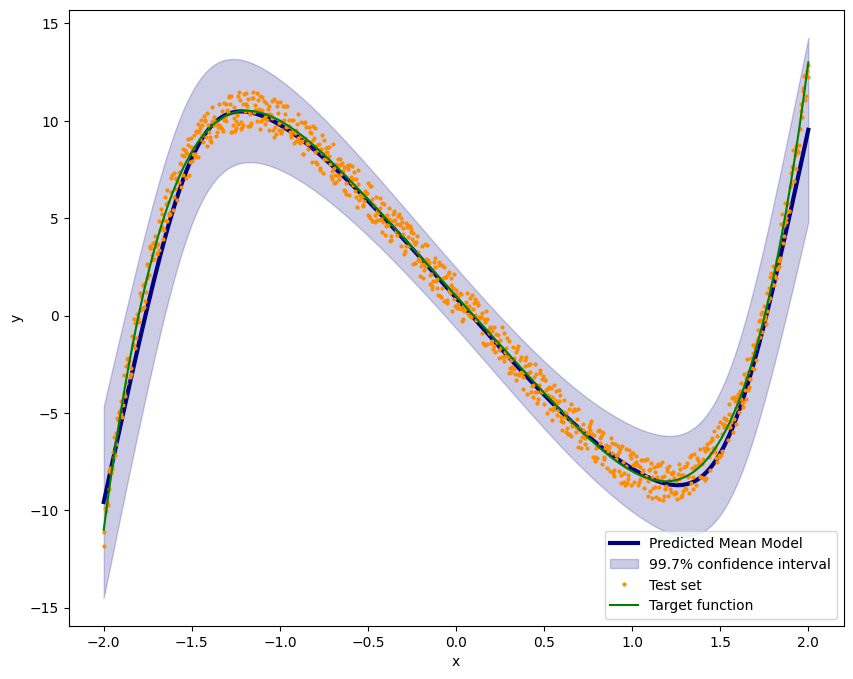

In [9]:
plt.figure(figsize=(10,8))
plt.plot(x_test,mean_model_results,color='navy',lw=3,label='Predicted Mean Model')
plt.fill_between(x_test.T[0],mean_model_results-3.0*std_model_results,mean_model_results+3.0*std_model_results,alpha=0.2,color='navy',label='99.7% confidence interval')
plt.plot(x_test,y_test,'.',color='darkorange',markersize=4,label='Test set')
plt.plot(x_test,clean_target(x_test),color='green',markersize=4,label='Target function')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')


Aside from the maximum on the left, the model is quite accurate.

I'm now going to test the effect of the dropout probability on the mean model's accuracy.

Just a brainstormed process of what I'm going to do:
* Have a list of multiple models, each with different dropout probabilities
* For each model:
    * Train it
    * Test it
    * Plot it

Running for model 0.0 - MSE = 2.37
Running for model 0.1 - MSE = 0.92
Running for model 0.2 - MSE = 0.98
Running for model 0.3 - MSE = 0.72
Running for model 0.4 - MSE = 0.54
Running for model 0.5 - MSE = 0.53


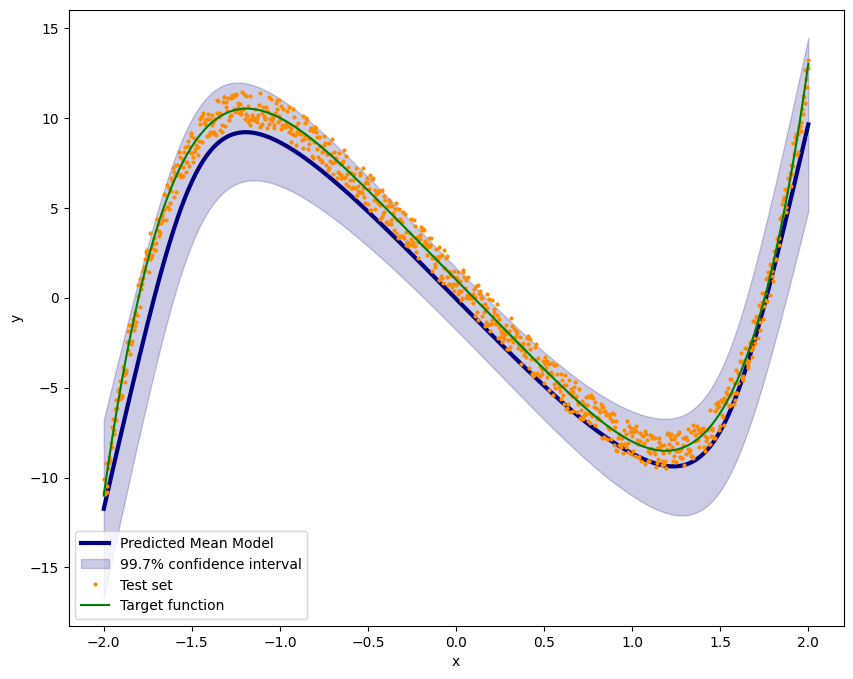

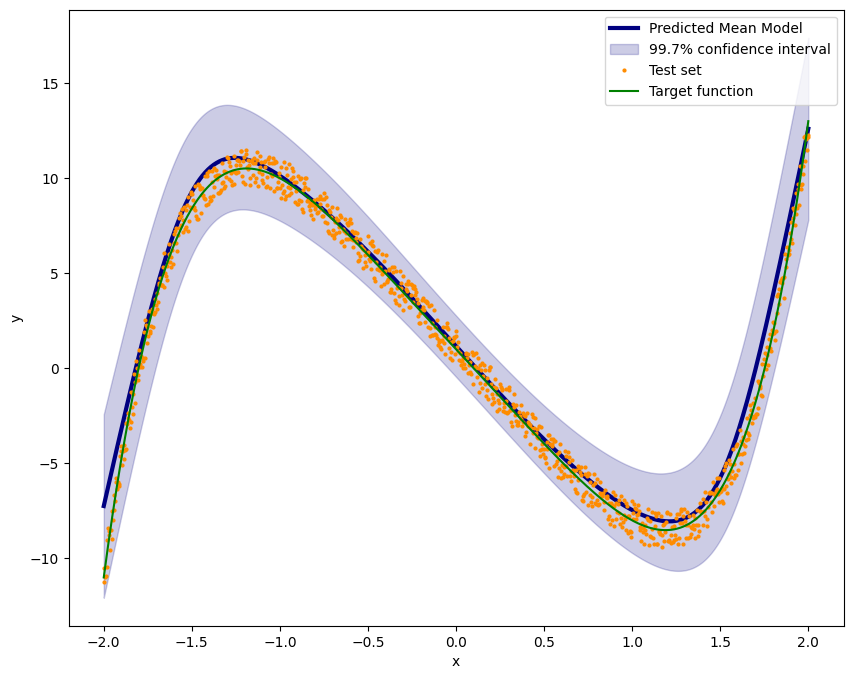

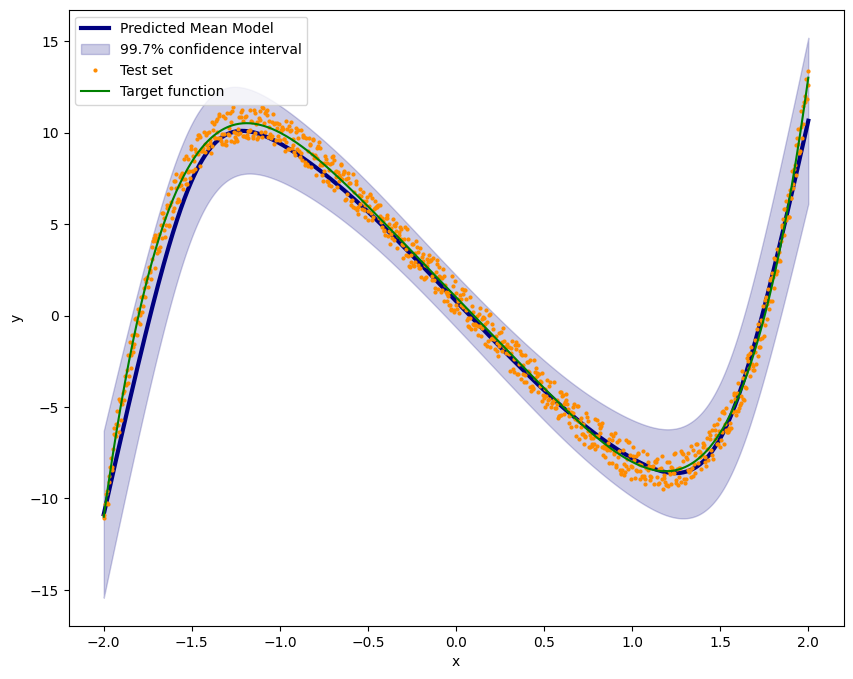

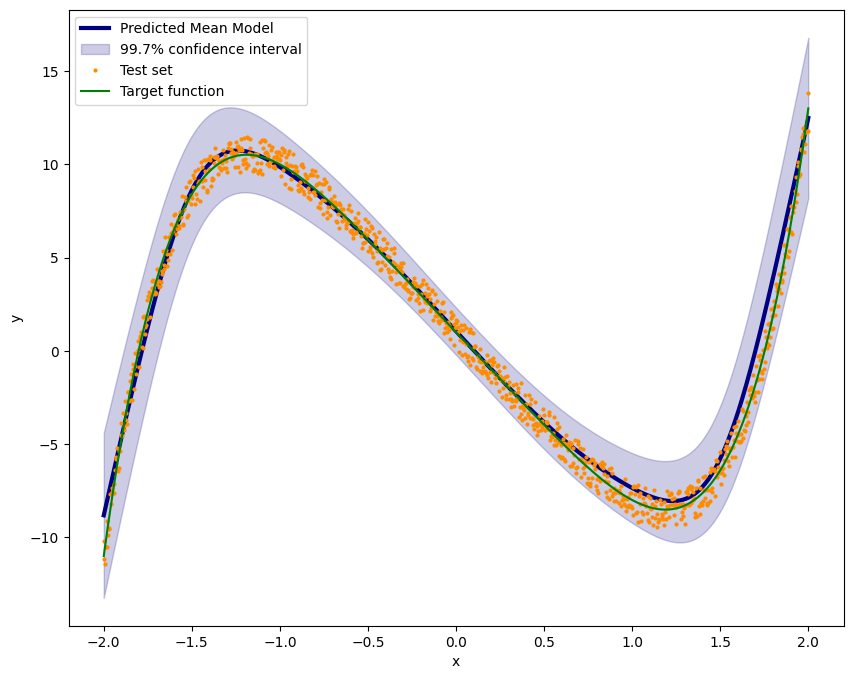

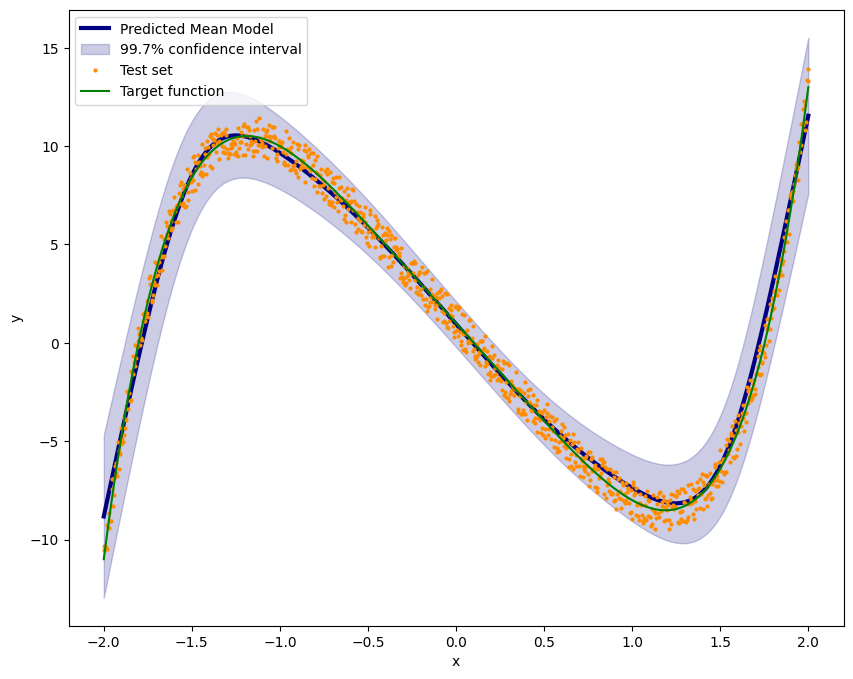

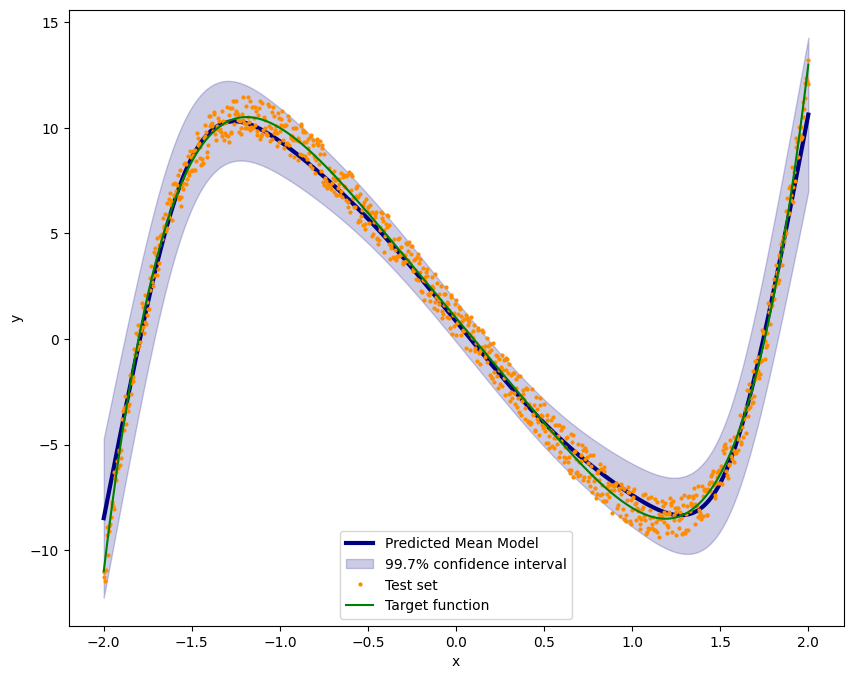

In [11]:
dropout_probabilities = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

#models_with_attributes because it's a list of tuples containing models and functions
models_with_attributes = [intialise_model(1000, 0.01, dropout) for dropout in dropout_probabilities]

for element in models_with_attributes:
    model = train_model(element, x_train, y_train, 1000)

    model.eval()
    mean_model_results, std_model_results, x_test, y_test = test_model(model, target)

    #evaluating MSE
    mse_loss = nn.MSELoss().to(device)
    mse = mse_loss(torch.unsqueeze(torch.tensor(mean_model_results), dim=1), y_test)

    print(f"Running for dropout probability {dropout_probabilities[models_with_attributes.index(element)]} - MSE = {mse:2.2f}")

    plt.figure(figsize=(10,8))
    plt.plot(x_test,mean_model_results,color='navy',lw=3,label='Predicted Mean Model')
    plt.fill_between(x_test.T[0],mean_model_results-3.0*std_model_results,mean_model_results+3.0*std_model_results,alpha=0.2,color='navy',label='99.7% confidence interval')
    plt.plot(x_test,y_test,'.',color='darkorange',markersize=4,label='Test set')
    plt.plot(x_test,clean_target(x_test),color='green',markersize=4,label='Target function')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')


It definitely prevents overfitting, but hollistically improving the model's performance? I don't think so. Most of the MSEs, and, therefore, to a very close approximation, cost values, of each model differ insignificantly, so their performances are similar.

A dropout probability of 0.3 seems to give the most accurate results